***Import all the libraries***

In [329]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt  
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler


# Preprocessing Steps
***Add the dataset and convert the date format to integer type.***

In [328]:
train_df = pd.read_csv('../data/cases_train_processed.csv')
test_df = pd.read_csv('../data/cases_test_processed.csv')

# Some preprocessing
# convert date from object type to int type
train_df["date_confirmation"] = pd.to_datetime(train_df["date_confirmation"]).dt.strftime("%Y%m%d").astype(int) 
test_df["date_confirmation"] = pd.to_datetime(test_df["date_confirmation"]).dt.strftime("%Y%m%d").astype(int) 


In [318]:
#use label encoder to normalize categorical features in dataframe
le = LabelEncoder()
categoricalFeatures = ['sex','province', 'country','key','additional_information', 'source']
for feat in categoricalFeatures:
    train_df[feat]= le.fit_transform(train_df[feat])
    test_df[feat]= le.fit_transform(test_df[feat])


In [319]:
train_df["outcome"].value_counts()

nonhospitalized    149990
hospitalized       125000
recovered           88137
deceased             4499
Name: outcome, dtype: int64

In [320]:
y = train_df['outcome']
X = train_df.drop(['outcome'], axis=1)

In [321]:
#split data into training and validation sets
training_data, validation_data, training_truth, validation_truth = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=11)

In [322]:
training_truth.value_counts()

nonhospitalized    119928
hospitalized       100092
recovered           70494
deceased             3586
Name: outcome, dtype: int64

***Using SMOTE for (partial) oversampling to solve the imbalanced labels problem.***

In [34]:
# oversample = SMOTE(random_state=0)
# training_data, training_truth = oversample.fit_resample(training_data, training_truth)

In [324]:
strategy = {'deceased':6000, 'recovered':100500, 'hospitalized':109000} 
os = SMOTE(sampling_strategy=strategy)
training_data, training_truth = os.fit_resample(training_data, training_truth)


In [325]:
training_truth.value_counts()

nonhospitalized    119928
hospitalized       109000
recovered          100500
deceased             6000
Name: outcome, dtype: int64

***Functions to calculate the recall, precision, and F1 score of the "deceased" label.***

In [53]:
# Scoring Functions
def calc_deceasedRecall(truth, prediction):
    return metrics.recall_score(truth,prediction, average=None)[0]

def calc_deceasedPrecision(truth, prediction):
    return metrics.precision_score(truth,prediction, average=None)[0]

def calc_deceasedF1(truth, prediction):
    return metrics.f1_score(truth,prediction, average=None)[0]


scoring_metrics = {
    'f1_deceased' : metrics.make_scorer(calc_deceasedF1),
    'recall_deceased' : metrics.make_scorer(calc_deceasedRecall),
    'overall_accuracy': metrics.make_scorer(metrics.accuracy_score),
    'overall_recall': metrics.make_scorer(metrics.recall_score , average='macro'),
}

# Hyperparameter Tuning
***Tuning the parameters and outputting the hyperparameter combinations as a dataframe.***
## 1. K-Nearest Neighbours Classifier

In [ ]:
param_grid = {
    'n_neighbors': [9, 30, 50],
    'weights': ['distance','uniform'],
    'metric': ['euclidean']
    }

knn_model = KNeighborsClassifier()
knn_grid_search = GridSearchCV(knn_model, param_grid=param_grid, scoring=scoring_metrics, cv = 2, refit='f1_deceased', n_jobs = -1, verbose = -1)
knn_grid_search.fit(training_data, training_truth)

In [ ]:

knn_results = pd.DataFrame(knn_grid_search.cv_results_)[['param_n_neighbors', 'param_weights', 'param_metric', 'mean_test_f1_deceased', 'rank_test_f1_deceased', 'mean_test_recall_deceased', 'mean_test_overall_accuracy', 'mean_test_overall_recall']]

# print(knn_grid_search.best_score_)
# knn_results.to_csv('../results/smote_knn.csv', index=False)

# Save as a csv file
knn_results.to_csv('../results/knn_params.csv')
knn_results

## 2. Random Forests Classifier

In [55]:
#RF parameter grid
rf_param_grid = {
        'max_depth': [29, 30],
        'n_estimators': [200, 250],
        'max_features': [10, 12]
        }

In [56]:
rf_model = RandomForestClassifier()
rf_grid_search = GridSearchCV(rf_model, param_grid = rf_param_grid, scoring = scoring_metrics, cv = 3, refit = 'f1_deceased', n_jobs = -1)
rf_grid_search.fit(training_data, training_truth)

GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [29, 30], 'max_features': [10, 12],
                         'n_estimators': [200, 250]},
             refit='f1_deceased',
             scoring={'f1_deceased': make_scorer(calc_deceasedF1),
                      'overall_accuracy': make_scorer(accuracy_score),
                      'overall_recall': make_scorer(recall_score, average=macro),
                      'recall_deceased': make_scorer(calc_deceasedRecall)})

In [67]:
rf_results = pd.DataFrame(rf_grid_search.cv_results_)[['param_max_depth', 'param_n_estimators', 'param_max_features', 'mean_test_f1_deceased', 'rank_test_f1_deceased', 'mean_test_recall_deceased', 'mean_test_overall_accuracy', 'mean_test_overall_recall']]
# Save as a csv file
rf_results.to_csv('../results/rf_params.csv')
rf_results

,param_max_depth,param_n_estimators,param_max_features,mean_test_f1_deceased,rank_test_f1_deceased,mean_test_recall_deceased,mean_test_overall_accuracy,mean_test_overall_recall
0,29,200,10,0.746093,1,0.799922,0.788746,0.788746
1,29,250,10,0.746018,2,0.799563,0.788650,0.788650
2,29,200,12,0.745096,8,0.797787,0.788444,0.788444
3,29,250,12,0.745856,3,0.799638,0.788688,0.788688
4,30,200,10,0.745638,4,0.798304,0.788679,0.788679
5,30,250,10,0.745595,6,0.798187,0.788621,0.788621
6,30,200,12,0.745363,7,0.796420,0.788525,0.788525
7,30,250,12,0.745610,5,0.798045,0.788563,0.788563


## 3. LightGBM Classifier

In [38]:
#Parameter grid for LGBM
param_grid = {
    'num_leaves': [60,90,120],
    'n_estimators': [100,200,300],
    'min_data_in_leaf': [60,80]
    }
    # took 1.5 hours

In [39]:
lgb_model = lgb.LGBMClassifier()
lgb_grid_search = GridSearchCV(lgb_model, param_grid=param_grid, scoring=scoring_metrics, cv=3, n_jobs=-1, refit='f1_deceased',verbose=-1)
lgb_grid_search.fit(training_data, training_truth)

[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60


GridSearchCV(cv=3, estimator=LGBMClassifier(), n_jobs=-1,
             param_grid={'min_data_in_leaf': [60, 80],
                         'n_estimators': [100, 200, 300],
                         'num_leaves': [60, 90, 120]},
             refit='f1_deceased',
             scoring={'f1_deceased': make_scorer(calc_deceasedF1),
                      'overall_accuracy': make_scorer(accuracy_score),
                      'overall_recall': make_scorer(recall_score, average=macro),
                      'recall_deceased': make_scorer(calc_deceasedRecall)},
             verbose=-1)

In [70]:
# output the parameter variations and scores in a table
lgbm_results = pd.DataFrame(lgb_grid_search.cv_results_)[['param_num_leaves', 'param_n_estimators', 'param_min_data_in_leaf','mean_test_f1_deceased', 'rank_test_f1_deceased','mean_test_recall_deceased', 'mean_test_overall_accuracy','mean_test_overall_recall']]
# Save as a csv file
lgbm_results.to_csv('../results/lgbm_params.csv')
lgbm_results

,param_num_leaves,param_n_estimators,param_min_data_in_leaf,mean_test_f1_deceased,rank_test_f1_deceased,mean_test_recall_deceased,mean_test_overall_accuracy,mean_test_overall_recall
0,60,100,60,0.736306,17,0.774540,0.781033,0.781033
1,90,100,60,0.748635,15,0.793109,0.789301,0.789301
2,120,100,60,0.756528,11,0.797737,0.794746,0.794746
3,60,200,60,0.756363,12,0.796495,0.794668,0.794668
4,90,200,60,0.761691,9,0.804341,0.799311,0.799311
5,120,200,60,0.764905,5,0.804816,0.802513,0.802513
6,60,300,60,0.761737,8,0.800188,0.799388,0.799388
7,90,300,60,0.766705,3,0.811996,0.803784,0.803784
8,120,300,60,0.769125,1,0.811045,0.805519,0.805519
9,60,100,80,0.735540,18,0.770095,0.779726,0.779726


### Predicting on the models with the best parameters

In [124]:
best_knn = KNeighborsClassifier(n_neighbors = 30, weights = 'distance', metric = 'euclidean')
best_knn.fit(training_data, training_truth)

KNeighborsClassifier(metric='euclidean', n_neighbors=30, weights='distance')

In [125]:
training_prediction = best_knn.predict(training_data)
validation_prediction = best_knn.predict(validation_data)

In [127]:
training_accuracy = metrics.accuracy_score(training_prediction, training_truth)
scores_training = metrics.classification_report(training_truth,training_prediction)
validation_accuracy = metrics.accuracy_score(validation_prediction, validation_truth)
scores_validation = metrics.classification_report(validation_truth,validation_prediction)
print("K-Nearest Neighbours Model Predictions (Post-Hyperparameter Tuning):\n")

print('TRAINING\nAccuracy score: {0:0.5f}'.format(training_accuracy))
print('Classification report: \n',scores_training)
print('\nVALIDATION\nAccuracy score: {0:0.5f}'.format(validation_accuracy))
print('Classification report: \n',scores_validation)

K-Nearest Neighbours Model Predictions (Post-Hyperparameter Tuning):

TRAINING
Accuracy score: 0.79504
Classification report: 
                  precision    recall  f1-score   support

       deceased       0.69      0.78      0.73    119928
   hospitalized       0.74      0.69      0.71    119928
nonhospitalized       1.00      1.00      1.00    119928
      recovered       0.76      0.71      0.74    119928

       accuracy                           0.80    479712
      macro avg       0.80      0.80      0.79    479712
   weighted avg       0.80      0.80      0.79    479712


VALIDATION
Accuracy score: 0.79604
Classification report: 
                  precision    recall  f1-score   support

       deceased       0.06      0.54      0.10       913
   hospitalized       0.85      0.66      0.75     24908
nonhospitalized       0.99      0.98      0.99     30062
      recovered       0.76      0.68      0.72     17643

       accuracy                           0.80     73526
      ma

In [51]:
training_accuracy = metrics.accuracy_score(training_prediction, training_truth)
scores_training = metrics.classification_report(training_truth,training_prediction)
validation_accuracy = metrics.accuracy_score(validation_prediction, validation_truth)
scores_validation = metrics.classification_report(validation_truth,validation_prediction)
print("K-Nearest Neighbours Model Predictions:\n")

print('TRAINING\nAccuracy score: {0:0.5f}'.format(training_accuracy))
print('Classification report: \n',scores_training)
print('\nVALIDATION\nAccuracy score: {0:0.5f}'.format(validation_accuracy))
print('Classification report: \n',scores_validation)

K-Nearest Neighbours Model Predictions:

TRAINING
Accuracy score: 0.78873
Classification report: 
                  precision    recall  f1-score   support

       deceased       0.69      0.78      0.73    119928
   hospitalized       0.74      0.68      0.71    119928
nonhospitalized       1.00      1.00      1.00    119928
      recovered       0.74      0.70      0.72    119928

       accuracy                           0.79    479712
      macro avg       0.79      0.79      0.79    479712
   weighted avg       0.79      0.79      0.79    479712


VALIDATION
Accuracy score: 0.79084
Classification report: 
                  precision    recall  f1-score   support

       deceased       0.05      0.49      0.09       913
   hospitalized       0.85      0.66      0.74     24908
nonhospitalized       0.99      0.99      0.99     30062
      recovered       0.73      0.66      0.70     17643

       accuracy                           0.79     73526
      macro avg       0.66      0.70 

### Predicting on the models with the best parameters
## TECHNICALLY WE DONT NEED THIS PART

In [61]:
# Fit the model on the training dataset
best_rf = RandomForestClassifier(max_depth=29, n_estimators=200, max_features=10)
#fit_params={'feature_name': 'auto', 'categorical_feature': 'auto'}
best_rf.fit(training_data, training_truth)

RandomForestClassifier(max_depth=29, max_features=10, n_estimators=200)

In [64]:
# predict on the training data
RF_training_prediction = best_rf.predict(training_data)
#predict on the validation data
RF_validation_prediction = best_rf.predict(validation_data)

In [65]:
training_accuracy = metrics.accuracy_score(RF_training_prediction, training_truth)
scores_training = metrics.classification_report(training_truth,RF_training_prediction)
validation_accuracy = metrics.accuracy_score(RF_validation_prediction, validation_truth)
scores_validation = metrics.classification_report(validation_truth,RF_validation_prediction)
print("Random Forest Model Predictions (Post-Hyperparameter Tuning):\n")

print('TRAINING\nAccuracy score: {0:0.5f}'.format(training_accuracy))
print('Classification report: \n',scores_training)
print('\nVALIDATION\nAccuracy score: {0:0.5f}'.format(validation_accuracy))
print('Classification report: \n',scores_validation)

Random Forest Model Predictions (Post-Hyperparameter Tuning):

TRAINING
Accuracy score: 0.82080
Classification report: 
                  precision    recall  f1-score   support

       deceased       0.76      0.81      0.78    119928
   hospitalized       0.80      0.70      0.74    119928
nonhospitalized       1.00      1.00      1.00    119928
      recovered       0.74      0.77      0.75    119928

       accuracy                           0.82    479712
      macro avg       0.82      0.82      0.82    479712
   weighted avg       0.82      0.82      0.82    479712


VALIDATION
Accuracy score: 0.81196
Classification report: 
                  precision    recall  f1-score   support

       deceased       0.06      0.45      0.11       913
   hospitalized       0.85      0.68      0.76     24908
nonhospitalized       0.99      0.99      0.99     30062
      recovered       0.73      0.71      0.72     17643

       accuracy                           0.81     73526
      macro avg

In [ ]:
fig, ax = plt.subplots(figsize = (20, 15), nrows = 1, ncols = 2) 
metrics.plot_confusion_matrix(best_rf, training_data, training_truth, cmap = plt.cm.Blues, ax = ax[0], values_format = '.6g') 
ax[0].set_title('RF - Confusion Matrix of Training Data')
metrics.plot_confusion_matrix(best_rf, validation_data, validation_truth, cmap = plt.cm.Blues, ax = ax[1], values_format = '.6g') 
ax[1].set_title('RF - Confusion Matrix of Validation Data')

# figure settings
fig.tight_layout()
fig.subplots_adjust(top=0.4)
fig.subplots_adjust(right=0.9)
#fig.savefig('../plots/lgbm_cm.png', bbox_inches='tight', pad_inches=0.3)

### Create and fit the LightGBM Classifier on the best parameters and record the scores

In [308]:
# Fit the model on the training dataset
best_lgbm = lgb.LGBMClassifier(num_leaves = 120, n_estimators=300,min_data_in_leaf=60)
#fit_params={'feature_name': 'auto', 'categorical_feature': 'auto'}
best_lgbm.fit(training_data, training_truth)

[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60


LGBMClassifier(min_data_in_leaf=60, n_estimators=300, num_leaves=120)

In [157]:
# predict on the training data
training_prediction = best_lgbm.predict(training_data)
#predict on the validation data
validation_prediction = best_lgbm.predict(validation_data)

### 3.2 Evaluating the model
*The metrics used to evaluate the model are the Accuracy score, Precision, Recall, F1-score, and the support count.*

In [102]:
# SMOTE
training_accuracy = metrics.accuracy_score(training_prediction, training_truth)
scores_training = metrics.classification_report(training_truth,training_prediction)
validation_accuracy = metrics.accuracy_score(validation_prediction, validation_truth)
scores_validation = metrics.classification_report(validation_truth,validation_prediction)
print("LightGBM Model Predictions (Post-Hyperparameter Tuning):\n")
print('TRAINING\nAccuracy score: {0:0.5f}'.format(training_accuracy))
print('Classification report: \n',scores_training)
print('\nVALIDATION\nAccuracy score: {0:0.5f}'.format(validation_accuracy))
print('Classification report: \n',scores_validation)
# lgb.LGBMClassifier(num_leaves = 120, n_estimators=300,min_data_in_leaf=60)


LightGBM Model Predictions (Post-Hyperparameter Tuning):

TRAINING
Accuracy score: 0.82156
Classification report: 
                  precision    recall  f1-score   support

       deceased       0.76      0.81      0.79    119928
   hospitalized       0.79      0.71      0.75    119928
nonhospitalized       1.00      1.00      1.00    119928
      recovered       0.74      0.77      0.75    119928

       accuracy                           0.82    479712
      macro avg       0.82      0.82      0.82    479712
   weighted avg       0.82      0.82      0.82    479712


VALIDATION
Accuracy score: 0.82590
Classification report: 
                  precision    recall  f1-score   support

       deceased       0.07      0.43      0.12       913
   hospitalized       0.86      0.71      0.78     24908
nonhospitalized       0.99      0.99      0.99     30062
      recovered       0.74      0.73      0.74     17643

       accuracy                           0.83     73526
      macro avg     

In [326]:
### TRIAL

best_lgbm.fit(train_d, train_t)
#  predict on the training data
training_p = best_lgbm.predict(train_d)
#predict on the validation data
validation_p = best_lgbm.predict(validation_data)
# SMOTE on deceased and recovered
training_accuracy = metrics.accuracy_score(training_p, train_t)
scores_training = metrics.classification_report(train_t,training_p)
validation_accuracy = metrics.accuracy_score(validation_p, validation_truth)
scores_validation = metrics.classification_report(validation_truth,validation_p)
print("LightGBM Model Predictions (Post-Hyperparameter Tuning):\n")
print('TRAINING\nAccuracy score: {0:0.5f}'.format(training_accuracy))
print('Classification report: \n',scores_training)
print('\nVALIDATION\nAccuracy score: {0:0.5f}'.format(validation_accuracy))
print('Classification report: \n',scores_validation)
# lgb.LGBMClassifier(num_leaves = 120, n_estimators=300,min_data_in_leaf=60)

# with about 10 values from age column changed to '35'

[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
LightGBM Model Predictions (Post-Hyperparameter Tuning):

TRAINING
Accuracy score: 0.87634
Classification report: 
                  precision    recall  f1-score   support

       deceased       0.95      0.32      0.47      6000
   hospitalized       0.82      0.82      0.82    109000
nonhospitalized       1.00      1.00      1.00    119928
      recovered       0.79      0.83      0.81    100500

       accuracy                           0.88    335428
      macro avg       0.89      0.74      0.78    335428
   weighted avg       0.88      0.88      0.87    335428


VALIDATION
Accuracy score: 0.87107
Classification report: 
                  precision    recall  f1-score   support

       deceased       0.57      0.12      0.20       913
   hospitalized       0.83      0.82      0.82     24908
nonhospitalized       0.99      0.99      0.99     30062
      recover

In [ ]:
deceased = 6000
precision = 58%
recall = 13%
f1 = 21%

*Also created a confusion matrix to provide a good insight to the predictions.*

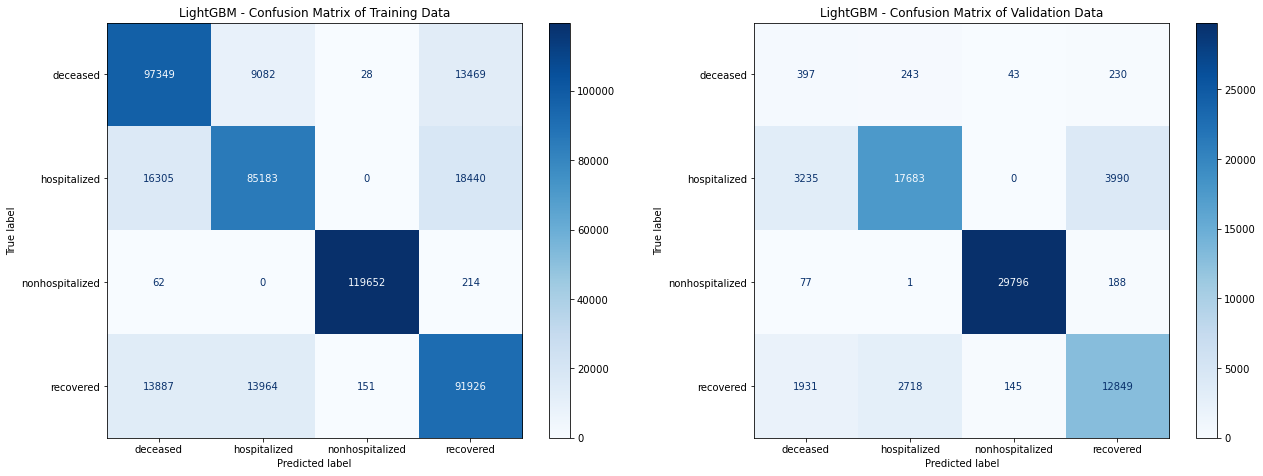

In [103]:
fig, ax = plt.subplots(figsize = (20, 15), nrows = 1, ncols = 2) 
metrics.plot_confusion_matrix(best_lgbm, training_data, training_truth, cmap = plt.cm.Blues, ax = ax[0], values_format = '.6g') 
ax[0].set_title('LightGBM - Confusion Matrix of Training Data')
metrics.plot_confusion_matrix(best_lgbm, validation_data, validation_truth, cmap = plt.cm.Blues, ax = ax[1], values_format = '.6g') 
ax[1].set_title('LightGBM - Confusion Matrix of Validation Data')

# figure settings
fig.tight_layout()
fig.subplots_adjust(top=0.4)
fig.subplots_adjust(right=0.9)
#fig.savefig('../plots/lgbm_cm.png', bbox_inches='tight', pad_inches=0.3)

## USING BEST MODEL TO PREDICT OUTCOME LABELS ON CASES_TEST_PROCESSED

In [80]:
test_df.dtypes

age                       float64
sex                         int64
province                    int64
country                     int64
latitude_x                float64
longitude_x               float64
date_confirmation           int64
additional_information      int64
source                      int64
key                         int64
latitude_y                float64
longitude_y               float64
confirmed_sum             float64
death_sum                 float64
recovered_sum             float64
incidence_rate_avg        float64
active_sum                float64
Case-Fatality_Ratio       float64
dtype: object

In [81]:
final_predictions = lgbm_model.predict(test_df)

In [87]:
final_predictions

array(['recovered', 'nonhospitalized', 'recovered', ...,
       'nonhospitalized', 'nonhospitalized', 'nonhospitalized'],
      dtype=object)

In [92]:
with open(os.path.join('../results/','predictions.txt'), "w") as outfile:
    outfile.write("\n".join(final_predictions))

In [95]:
def check_if_file_valid(filename):
    assert filename.endswith('predictions.txt'), 'Incorrect filename' 
    f = open(filename).read()
    l = f.split('\n')
    assert len(l) == 46500, 'Incorrect number of items'
    assert (len(set(l)) == 4), 'Wrong class labels'
    return 'The predictions file is valid'

In [98]:
check_if_file_valid('../results/predictions.txt')

'The predictions file is valid'